## superresolution
single image superresolution (4x zoom)
- depthwise attention mechanism [[paper]](https://arxiv.org/abs/1908.02648)
- relativistic losses [[paper]](https://arxiv.org/abs/1807.00734)
- residual in residual architecture [[paper]](https://arxiv.org/abs/1505.04597)
- subpixel convolution / pixelshuffle [[paper]](https://arxiv.org/abs/1609.05158)
- running on [tensorflow/google colab](https://colab.research.google.com/) AND on [plaidml](https://www.intel.ai/plaidml/)
- using the famous [Set14](https://www.google.com/search?q=set14) dataset ONLY (with heavy augmentation) - no validation needed

jupyter notebook by [Benjamin Wegener](https://scholar.google.de/citations?user=yEn9St8AAAAJ) from [github](https://www.github.com/BenjaminWegener/keras-examples)

### options


In [0]:
run_on_google_colab = True #use PlaidML as Backend, change this to 'True' to run on colab/tf
epochs = 2500 #Number of epochs to train
scale = 4 #How much should we upscale images
channels = 3 #channels of low resolution image
batch_size = 4 #what batch-size should we use (decrease if you encounter video memory errors)
height_lr = 128 #height of low resolution image
width_lr = height_lr #width of low resolution image
generator_learningrate = 0.0002 #learning rate of generator
discriminator_learningrate = 0.0002 #learning rate of discriminator
iterations = 5 #how often to train per epoch 
height_hr = int(height_lr * scale) # High-resolution image height
width_hr = int(width_lr * scale) # High-resolution image width

### imports

In [2]:
import os
if run_on_google_colab:
    %cd /content
    !git clone https://github.com/BenjaminWegener/superresolution-android #download Dataset
    %cd superresolution-android
else:
    os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
import numpy as np
from keras.models import Model, Input, load_model
from keras.layers import *
from keras.losses import *
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import LambdaCallback
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import random
%matplotlib inline    

/content
Cloning into 'superresolution-android'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 93.77 MiB | 55.40 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/superresolution-android


Using TensorFlow backend.


### function for image visualization

In [0]:
def show(tensors):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig = plt.figure()
    for i in range(len(tensors)):
        try:
            tensors[i] = np.squeeze(tensors[i], axis = 0)
        except:
            pass
        tensors[i] = (tensors[i] + 1.) * 127.5
        fig.add_subplot(1,len(tensors), i + 1)
        plt.imshow(tensors[i].astype(np.uint8), interpolation = 'nearest')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.show()

### dataset function

In [0]:
# return batch of augmented train and target images with quantity n_samples
def get_batch(n_samples, height, width, channels):
    # define a ImageGenerator instance from keras with augmentations
    image_gen = ImageDataGenerator(rotation_range=360,
                           width_shift_range=0.5,
                           height_shift_range=0.5,
                           zoom_range=[0.7, 2.0],
                           horizontal_flip=True,
                           vertical_flip=True,
                           fill_mode='reflect',
                           data_format='channels_last',
                           brightness_range=[0.5, 1.5])
    #seed for random augmentations
    random_seed = int(random.random() * 100000)
    #generate augmented images
    y_train = image_gen.flow_from_directory('dataset', target_size = (height * scale, width * scale), batch_size = n_samples, class_mode = None, seed = random_seed)
    y_train = y_train.__getitem__(0).copy() #fix for 'array doesn't own its data'
    x_train = np.empty((len(y_train), height, width, channels))
    for i in range(n_samples):
        # source images are zoomed to 25%
        input_size = height * scale
        output_size = height
        fraction = input_size // output_size
        x_train[i] = y_train[i].reshape((output_size, fraction, output_size, fraction, channels)).mean(3).mean(1)
    #normalize images to [-1, 1]
    x_train = x_train/127.5 - 1.
    y_train = y_train/127.5 - 1.
    return x_train, y_train

### base functions

In [0]:
def fast_normalization(x): # use clipping instead of batchnormalization for network stabilization
    return Lambda(lambda x: K.clip(x, -1, 1), output_shape=lambda s: (s[0], s[1], s[2], s[3]))(x)

def upsample(inputs, kernel_size): #combined pixel shuffle and squeeze
    x = inputs
    x = Conv2D(12, kernel_size = kernel_size, activation = 'tanh', padding = 'same', strides = 1)(x)

    x1 = x
    x = GlobalAveragePooling2D()(x)
    #x = Dense(3, activation = 'relu')(x)
    x = Dense(12, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 12))(x)
    x = Multiply()([x1, x])
    x = fast_normalization(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 3, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    return x

def residual_block(inputs): #combined pixel shuffle and squeeze
    x = inputs
    x = Conv2D(32, kernel_size = 9, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = SeparableConv2D(128, kernel_size = 9, activation = 'tanh', padding = 'same')(x) # rapidly increase speed at slightly worse results
    x = fast_normalization(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 32, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    #---
    x1 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(8, activation = 'relu')(x) #reduction like in RCAN 
    x = Dense(32, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 32))(x)
    x = Multiply()([x1, x])
    x = Add()([inputs, x]) 
    return x

### build generator model

In [6]:
inputs = Input(shape = (height_lr, width_lr, channels))

x1 = upsample(inputs, 2)
x2 = upsample(inputs, 3)
x3 = upsample(inputs, 5)
x4 = upsample(inputs, 7)
x5 = Concatenate()([x1, x2, x3, x4])
y1 = upsample(x5, 2)
y2 = upsample(x5, 3)
y3 = upsample(x5, 5)
y4 = upsample(x5, 7)
y5 = Concatenate()([y1, y2, y3, y4])
outputs =  Conv2D(3, kernel_size = 9, activation = 'tanh', padding = 'same', strides = 1)(y5)
outputs = Concatenate()([outputs, UpSampling2D(size = 4)(inputs)])
outputs =  Conv2D(3, kernel_size = 9, activation = 'tanh', padding = 'same', strides = 1)(y5)
#outputs = fast_normalization(outputs)
generator = Model(inputs = inputs, outputs = outputs)

#generator.summary()

### build discriminator model

In [7]:
# define the discriminator model
x = inputs = Input(shape = (height_hr, width_hr, channels))
x = SeparableConv2D(32, (9, 9), padding='same', activation = 'tanh')(x)
for _ in range(10):
    x = residual_block(x)
x = SeparableConv2D(1, (9, 9), padding='same', activation = 'hard_sigmoid')(x)

x = GlobalAveragePooling2D()(x)
x = Dense(1)(x)
discriminator = Model(inputs = inputs, outputs = x)
discriminator.summary()
discriminator.compile(optimizer = Adam(discriminator_learningrate), loss = 'mse')


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 512, 512, 32) 371         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 32) 82976       separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 256, 256, 128 6816        conv2d_11[0][0]                  
____________________________________________________________________________________________

### relativistic losses

In [0]:
target_image = Input(shape=(height_hr, width_hr, 3))
source_image = Input(shape=(height_lr, width_lr, 3))
fake_image = generator(source_image)
disc_r = discriminator(target_image) # C(x_r)
disc_f = discriminator(fake_image) # C(x_f)

# Define generator and discriminator losses according to RaGAN described in Jolicoeur-Martineau (2018).
# Dummy predictions and trues are needed in Keras.
def rel_disc_loss(y_true, y_pred):
    epsilon=0.000001
    return -(K.mean(K.log(K.sigmoid(disc_r - K.mean(disc_f, axis=0))+epsilon), axis=0)\
              +K.mean(K.log(1-K.sigmoid(disc_f - K.mean(disc_r, axis=0))+epsilon), axis=0))

def rel_gen_loss(y_true, y_pred):
    epsilon=0.000001
    return -(K.mean(K.log(K.sigmoid(disc_f - K.mean(disc_r, axis=0))+epsilon), axis=0)\
              +K.mean(K.log(1-K.sigmoid(disc_r - K.mean(disc_f, axis=0))+epsilon), axis=0))

### build combined models

In [9]:
# Define trainable generator and discriminator
generator_train = Model([source_image, target_image], [disc_r, disc_f])
discriminator.trainable = False
generator_train.compile(Adam(lr = generator_learningrate, beta_1=0.5, beta_2=0.999), loss=[rel_gen_loss, None])
generator_train.summary()

discriminator_train = Model([source_image, target_image], [disc_r, disc_f])
generator.trainable = False
discriminator.trainable = True
discriminator_train.compile(Adam(lr = discriminator_learningrate, beta_1=0.5, beta_2=0.999), loss=[rel_disc_loss, None])
discriminator_train.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512, 512, 3)  19923       input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            906438      input_3[0][0]                    
                                                                 model_1[1][0]             

### train

epoch 9 dloss: 0.29163867 gloss: 4.016161 train ratio: 0.0064 0.0009431790764000006


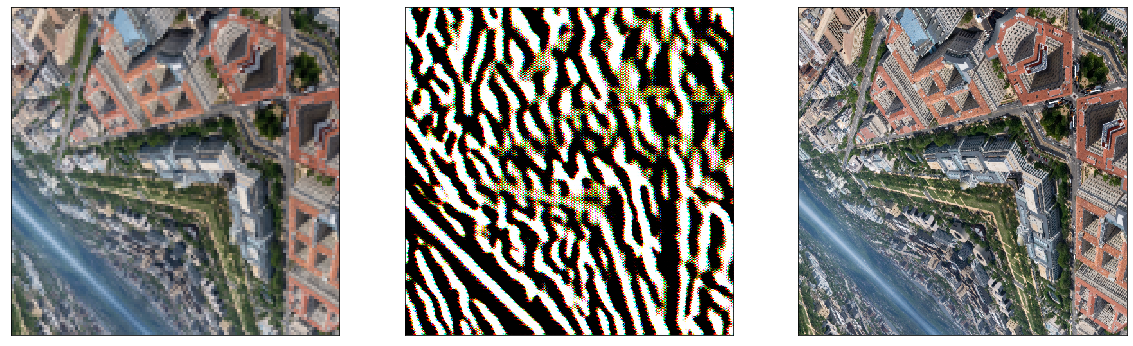

trying to save weights... success.
Found 21 images belonging to 1 classes.


KeyboardInterrupt: ignored

In [47]:
#load checkpoint & compile the generator network
print('trying to load last saved weights...', end = ' ')
try:
    generator.load_weights('generator_weights')
    discriminator.load_weights('discriminator_weights')
    print('success.')
except:
    print('failed')
    pass

# manually enumerate epochs
for i in range(epochs):
    source_image, target_image = get_batch(batch_size, height_lr, width_lr, channels)
    dummy_y = np.zeros((batch_size, 1), dtype=np.float32)
    
    for _ in range(iterations):
        dloss = discriminator_train.train_on_batch([source_image, target_image], dummy_y)
        gloss = generator_train.train_on_batch([source_image, target_image], dummy_y)

    if np.mean(gloss) > np.mean(dloss) * 1.5:
        generator_learningrate *= 1.1
        generator_train.compile(Adam(lr = generator_learningrate, beta_1=0.5, beta_2=0.999), loss=[rel_gen_loss, None])

    if np.mean(dloss) > np.mean(gloss) * 1.5:
        discriminator_learningrate *= 1.1
        discriminator_train.compile(Adam(lr = discriminator_learningrate, beta_1=0.5, beta_2=0.999), loss=[rel_disc_loss, None])

    # summarize performance
    #loss = mean_squared_error(target_image, generator.predict(source_image))
    test_source_image, test_target_image = get_batch(1, height_lr, width_lr, channels)
    test_fake_image = generator.predict(test_source_image)
    test_discriminator_target_image = discriminator.predict(test_target_image)
    test_discriminator_fake_image = discriminator.predict(test_fake_image)

    clear_output()
    print('epoch', i+1, 'dloss:', np.mean(dloss), 'gloss:', np.mean(gloss), 'train ratio:', discriminator_learningrate, generator_learningrate)

    show([test_source_image, test_fake_image, test_target_image])
 
    try:
        print('trying to save weights...', end = ' ')
        generator.save_weights('generator_weights')
        discriminator.save_weights('discriminator_weights')
        print('success.')
    except:
        print('failed.')  

### validate on complete picture

In [0]:
# show image in actual size https://stackoverflow.com/a/42314798/
def display_image_in_actual_size(im_data):
    dpi = 100
    height, width, depth = im_data.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray')
    plt.show()

In [0]:
from PIL import Image
img = np.array(Image.open('./lenna.png'))
img = img /127.5 -1
x = inputs = Input(shape = img.shape)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = upsample(x)
x = upsample(x)

my_model = Model(inputs = inputs, outputs = x)
print('trying to load last saved weights...', end = ' ')
try:
    my_model.load_weights('superresolutionDA_weights')
    print('success.')
except:
    print('failed')
    pass
predicted = my_model.predict(np.expand_dims((img), 0))
print('ground truth:')
img = (img + 1) * 127.5
display_image_in_actual_size(img.astype(np.uint8))
print('superresolution:')
predicted = np.squeeze(predicted)
predicted = (predicted + 1) * 127.5
display_image_in_actual_size(predicted.astype(np.uint8))
predicted = Image.fromarray(predicted.astype(np.uint8))
print('trying to save image as \'superresolutionDA_result.png\'...', end = ' ')
try:
    predicted.save('superresolutionDA_result.png', "PNG")
    print('success.')
except:
    print('failed.')
    pass

### upscale with esrgan

In [0]:
!wget https://github.com/hieubkset/Keras-Image-Super-Resolution/raw/master/checkpoints/esrgan-10.h5

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, PReLU, Add, Lambda
from tensorflow.keras.models import Model


def dense_block(input_tensor, filters, scale=0.2):
    x_1 = input_tensor

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = LeakyReLU(alpha=0.2)(x)
    x = x_2 = Add()([x_1, x])

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = x_3 = Add()([x_1, x_2, x])

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Add()([x_1, x_2, x_3, x])

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Add()([x_1, x_2, x_3, x])

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Lambda(lambda x: x * scale)(x)
    x = Add()([x_1, x])

    return x


def sub_pixel_conv2d(scale=2, **kwargs):
    return Lambda(lambda x: tf.depth_to_space(x, scale), **kwargs)


def upsample(input_tensor, filters):
    x = Conv2D(filters=filters*4, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = sub_pixel_conv2d(scale=2)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    return x


def generator(filters=64, n_dense_block=16, n_sub_block=2):
    inputs = Input(shape=(None, None, 3))

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(inputs)
    x = x_1 = LeakyReLU(alpha=0.2)(x)

    for _ in range(n_dense_block):
        x = dense_block(x, filters=filters)

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Lambda(lambda x: x * 0.2)(x)
    x = Add()([x_1, x])

    for _ in range(n_sub_block):
        x = upsample(x, filters)

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=3, kernel_size=3, strides=1, padding='same')(x)

    return Model(inputs=inputs, outputs=x)

In [0]:
test =generator()
test.load_weights('esrgan-10.h5')

In [0]:
from PIL import Image
img = np.array(Image.open('./Set14/d2.jpg'))
img = img /127.5 -1

predicted = test.predict(np.expand_dims((img), 0))
print('ground truth:')
img = (img + 1) * 127.5
display_image_in_actual_size(img.astype(np.uint8))
print('superresolution:')
predicted = np.squeeze(predicted)
predicted = (predicted + 1) * 127.5
display_image_in_actual_size(predicted.astype(np.uint8))
predicted = Image.fromarray(predicted.astype(np.uint8))
print('trying to save image as \'superresolutionDA_result.png\'...', end = ' ')
try:
    predicted.save('superresolutionDA_result.png', "PNG")
    print('success.')
except:
    print('failed.')
    pass